In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pathlib
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

from tensorflow.keras.preprocessing.image import load_img

In [ ]:
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/DATASET/Skin cancer ISIC The International Skin Imaging Collaboration/Train")

data_dir_test = pathlib.Path("/content/gdrive/MyDrive/DATASET/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [ ]:
import PIL
data_dir_test = pathlib.Path("/content/gdrive/MyDrive/DATASET/Skin cancer ISIC The International Skin Imaging Collaboration/Test")
#total to be trained images
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

#total test images
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


Found 6739 files belonging to 9 classes.


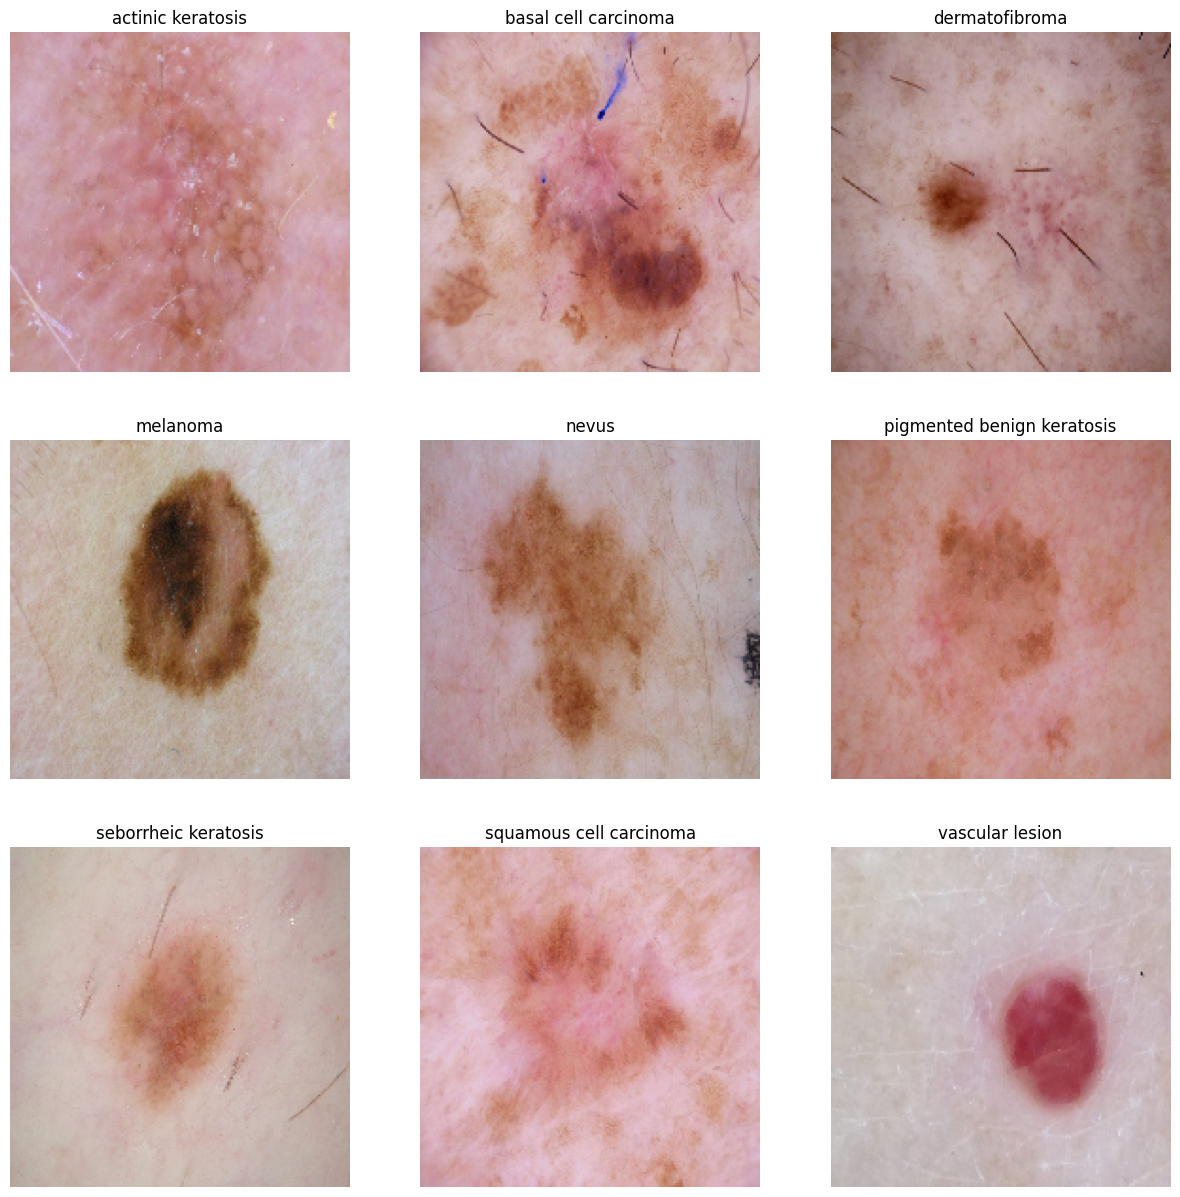

In [ ]:
image_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,image_size=(180,180),
                                                                    label_mode='categorical',seed=123)

class_names = image_dataset.class_names

#to store all images in dictionary
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))


plt.figure(figsize=(15,15))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

In [ ]:
def class_distribution_count(directory):

    #counting no of images
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))

    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]

    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,melanoma,438
1,dermatofibroma,95
2,actinic keratosis,114
3,basal cell carcinoma,376
4,squamous cell carcinoma,181
5,seborrheic keratosis,77
6,pigmented benign keratosis,462
7,nevus,357
8,vascular lesion,139


<Axes: xlabel='No. of Image', ylabel='Class'>

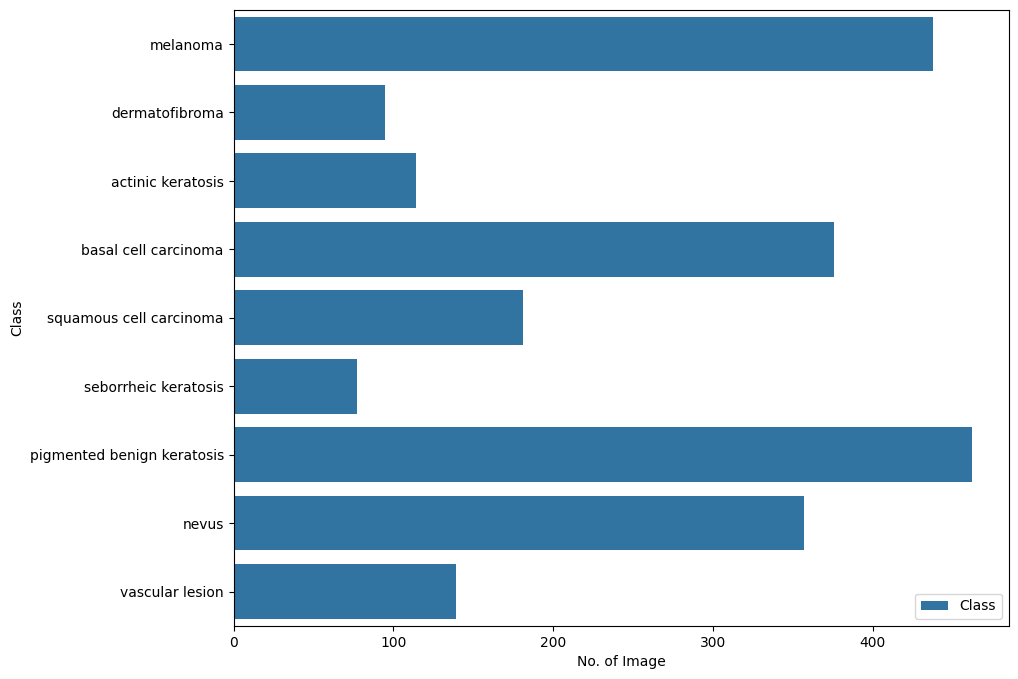

In [ ]:
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")

In [ ]:
!pip install Augmentor

In [ ]:
path_to_training_dataset="/content/gdrive/MyDrive/DATASET/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

9000


In [ ]:
# training the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=32,
                                                               image_size=(180,180), label_mode='categorical',
                                                               seed=123,subset="training",
                                                               validation_split=0.2)

Found 11239 files belonging to 9 classes.
Using 8992 files for training.


In [ ]:
val_ds =tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,
                                                            image_size=(180,180), label_mode='categorical',
                                                            seed=123,subset="validation",
                                                            validation_split=0.2)

Found 11239 files belonging to 9 classes.
Using 2247 files for validation.


In [ ]:

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
from tensorflow.keras.layers import Rescaling
import PIL
import pathlib

data_dir_train = pathlib.Path("/content/gdrive/MyDrive/DATASET/Skin cancer ISIC The International Skin Imaging Collaboration/Train")  # Assuming this path is still correct
image_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    batch_size=32,
    image_size=(180, 180),
    label_mode='categorical',
    seed=123
)
class_names = image_dataset.class_names
model = Sequential()


model.add(Rescaling(1./255, input_shape=(180,180,3)))
#First Convulation layer 1
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer 2
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer 3
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())


model.add(layers.Dense(128,activation='relu'))


model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()




Found 11239 files belonging to 9 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       6,553,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

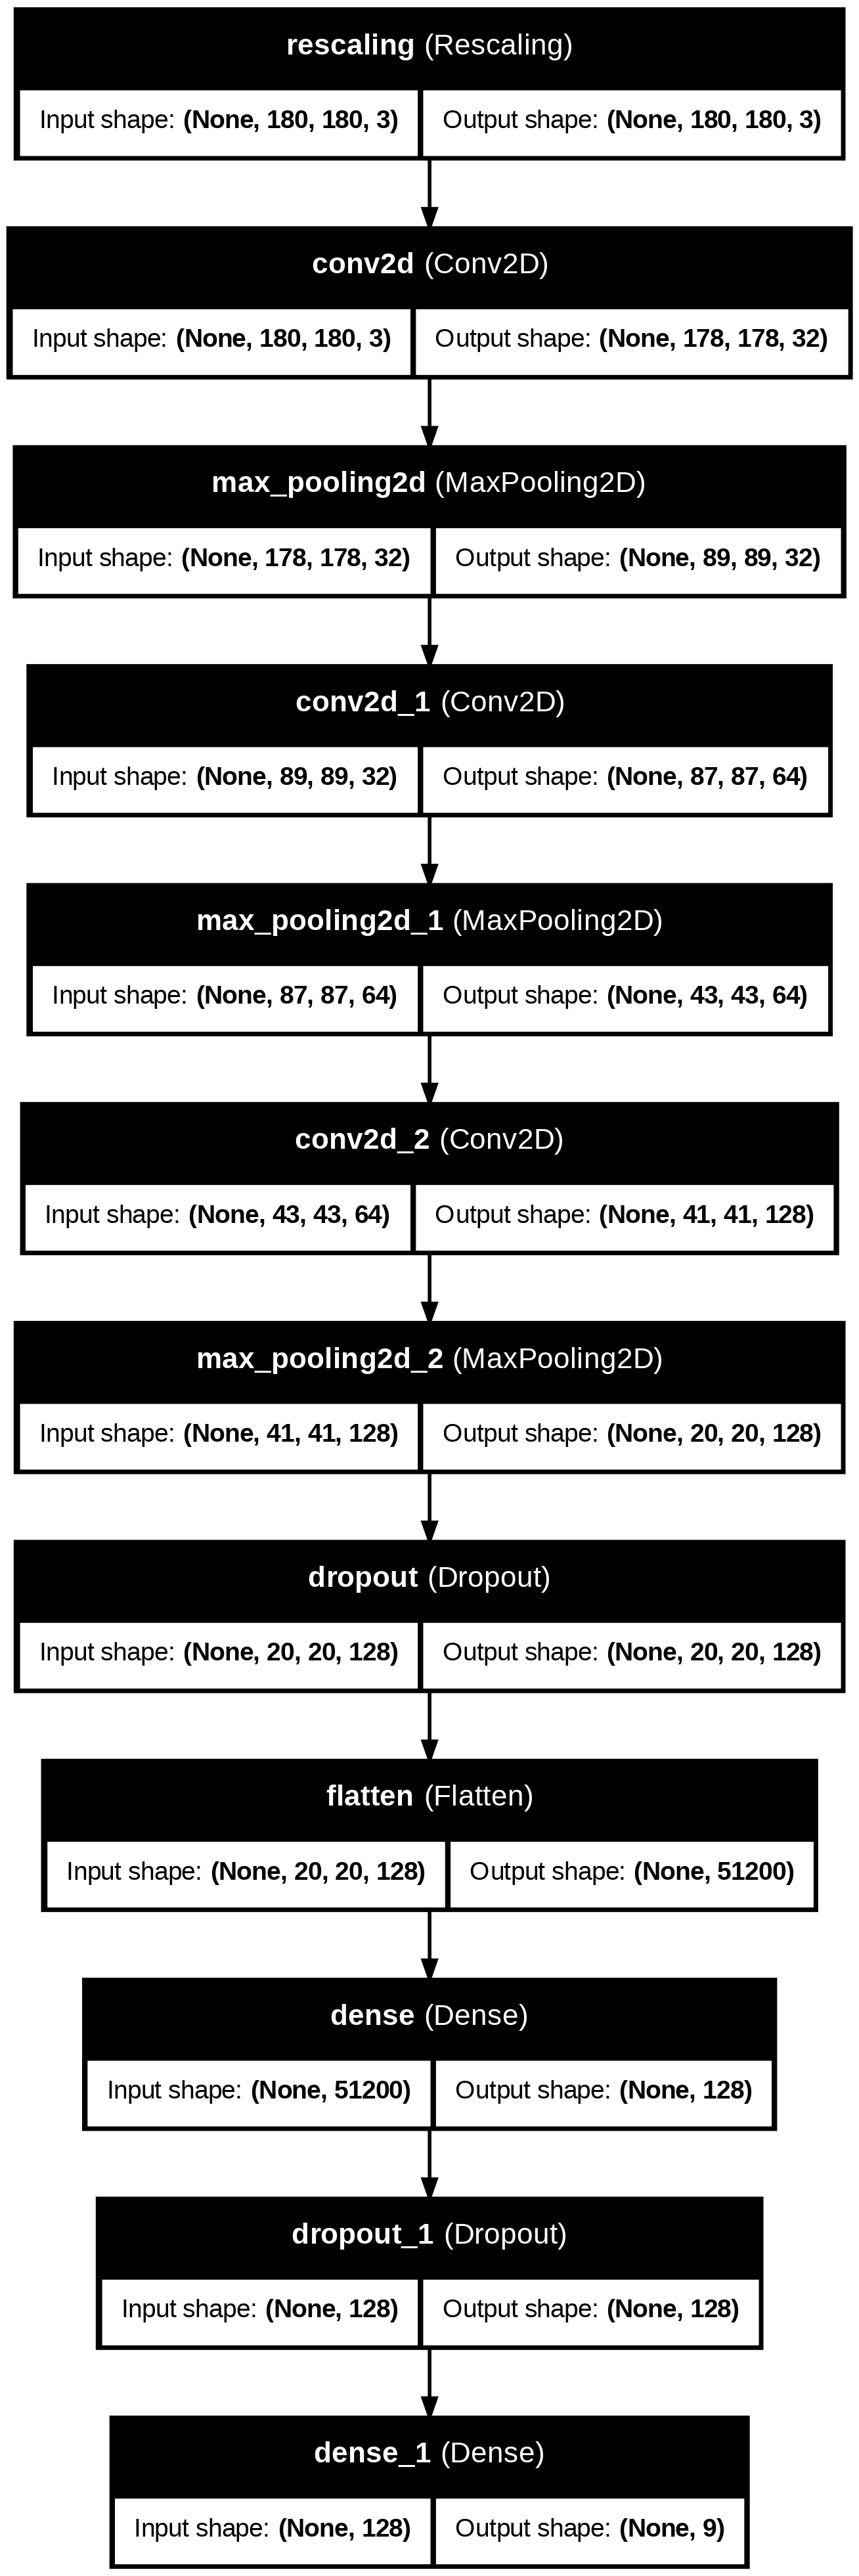

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:


model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

checkpoint = ModelCheckpoint("model.keras",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)



In [ ]:
epochs = 17
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[checkpoint,earlystop])

Epoch 1/17
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.2394 - loss: 1.9380
Epoch 1: val_accuracy improved from -inf to 0.46640, saving model to model.keras
281/281 ━━━━━━━━━━━━━━━━━━━━ 178s 636ms/step - accuracy: 0.2397 - loss: 1.9372 - val_accuracy: 0.4664 - val_loss: 1.4207
Epoch 2/17
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4762 - loss: 1.4033
Epoch 2: val_accuracy improved from 0.46640 to 0.57588, saving model to model.keras
281/281 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.4763 - loss: 1.4030 - val_accuracy: 0.5759 - val_loss: 1.1433
Epoch 3/17
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5721 - loss: 1.1611
Epoch 3: val_accuracy improved from 0.57588 to 0.65287, saving model to model.keras
281/281 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - accuracy: 0.5721 - loss: 1.1610 - val_accuracy: 0.6529 - val_loss: 1.0011
Epoch 4/17
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6558 - loss: 0.9511
Epoch 4: val_accuracy improved from 0.65287 t

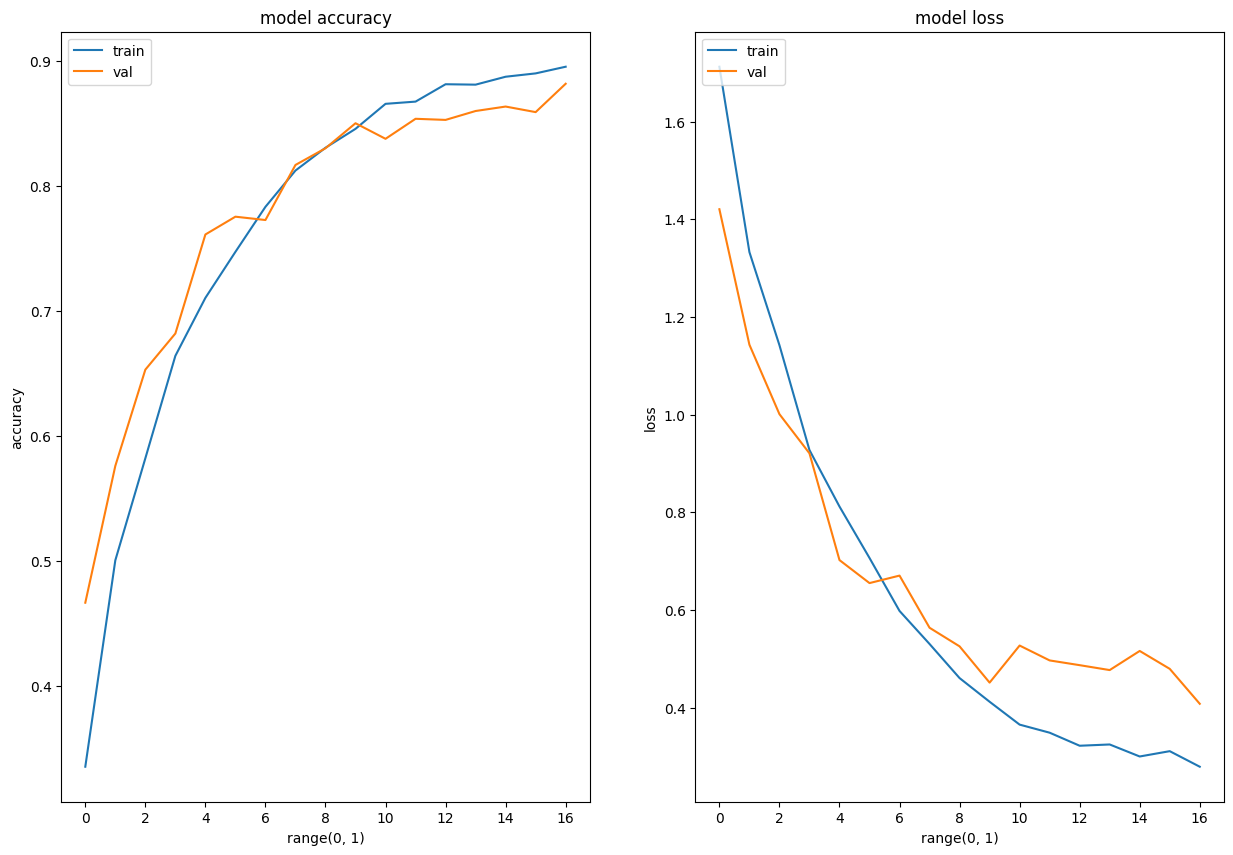

In [ ]:
epochs_range = range(earlystop.stopped_epoch+1)
#plotting model Accuracy and model loss
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)


plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
from glob import glob
Test_image_path = os.path.join(data_dir_test, class_names[1], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[1] +'\n'+ "Predictive Class "+pred_class )